In [3]:
# First import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Now load the dataset
df = pd.read_csv('online_retail_II.csv', encoding='ISO-8859-1')

# Preview
print("Rows and columns:", df.shape)
df.head()

Rows and columns: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
# checking data types and missing values in the dataset
df.info()
df.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Invoice,1067371,53628,537434,1350,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,1067371,5305,85123A,5829,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,1062989,5698,WHITE HANGING HEART T-LIGHT HOLDER,5918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,1067371.0,NaN,NaN,NaN,9.938898,172.705794,-80995.0,1.0,3.0,10.0,80995.0
InvoiceDate,1067371,47635,2010-12-06 16:57:00,1350,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,1067371.0,NaN,NaN,NaN,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0
Customer ID,824364.0,NaN,NaN,NaN,15324.638504,1697.46445,12346.0,13975.0,15255.0,16797.0,18287.0
Country,1067371,43,United Kingdom,981330,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# We’ll remove missing Customer IDs (since RFM depends on it) and fix column names for consistency.
# Clean column names
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

# Drop rows with missing Customer ID
df = df.dropna(subset=['Customer_ID'])

# Convert Customer_ID to integer
df['Customer_ID'] = df['Customer_ID'].astype(int)


In [8]:
# We’ll convert InvoiceDate to proper datetime format.

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
# Remove Zero Quantities
df = df[df['Quantity'] > 0]

In [12]:
# Creating TotalAmount Column: This represents the transaction value per row.
df['TotalAmount'] = df['Quantity'] * df['Price']

In [13]:
# Preview
print("Unique customers:", df['Customer_ID'].nunique())
print("Total transactions:", len(df))
print("Total revenue: £", round(df['TotalAmount'].sum(), 2))

df.head()

Unique customers: 5881
Total transactions: 805620
Total revenue: £ 17743429.18


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


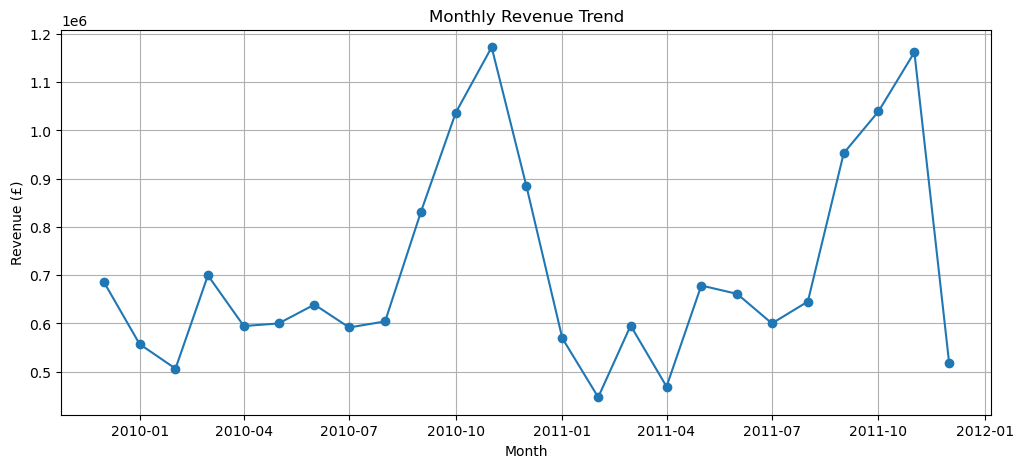

In [15]:
# Now take a view by graphical visualization
# Monthly Revenue Trend 

# Convert InvoiceDate to month format
df['InvoiceMonth'] = df['InvoiceDate'].apply(lambda x: pd.Timestamp(x).to_period('M').to_timestamp())

# Group data by month and calculate total revenue
monthly = df.groupby('InvoiceMonth')['TotalAmount'].sum()
monthly = monthly.reset_index()

# Plot the trend
plt.figure(figsize=(12, 5))
plt.plot(monthly['InvoiceMonth'], monthly['TotalAmount'], 'o-')

# Add labels and title
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue (£)')

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

In [16]:
# find the most recent purchase date in our dataset
latest_date = df['InvoiceDate'].max()
print("Last purchase date in data:", latest_date)

Last purchase date in data: 2011-12-09 12:50:00


In [17]:
# RFM = Recency, Frequency, and Monetary
# group data by Customer_ID
rfm = df.groupby('Customer_ID').agg({
    'InvoiceDate': lambda x: x.max(),   # last purchase date
    'Invoice': 'nunique',               # number of unique invoices
    'TotalAmount': 'sum'                # total money spent
}).reset_index()

# rename columns to simple names
rfm.columns = ['Customer_ID', 'LastPurchaseDate', 'Frequency', 'Monetary']

rfm.head()

,Customer_ID,LastPurchaseDate,Frequency,Monetary
0,12346,2011-01-18 10:01:00,12,77556.46
1,12347,2011-12-07 15:52:00,8,5633.32
2,12348,2011-09-25 13:13:00,5,2019.40
3,12349,2011-11-21 09:51:00,4,4428.69
4,12350,2011-02-02 16:01:00,1,334.40


In [18]:
# recency = (latest date - last purchase date)
rfm['Recency'] = (latest_date - rfm['LastPurchaseDate']).dt.days

# Now dropping LastPurchaseDate
rfm = rfm.drop('LastPurchaseDate', axis=1)

rfm.head()

,Customer_ID,Frequency,Monetary,Recency
0,12346,12,77556.46,325
1,12347,8,5633.32,1
2,12348,5,2019.40,74
3,12349,4,4428.69,18
4,12350,1,334.40,309


In [20]:
# preview the data info
print(rfm.shape)
rfm.describe()

(5881, 4)


,Customer_ID,Frequency,Monetary,Recency
count,5881.000000,5881.000000,5881.000000,5881.000000
mean,15314.674205,6.287196,3017.076888,200.457745
std,1715.429759,13.012879,14734.128619,209.474135
min,12346.000000,1.000000,0.000000,0.000000
25%,13833.000000,1.000000,347.800000,25.000000
50%,15313.000000,3.000000,897.620000,95.000000
75%,16797.000000,7.000000,2304.180000,379.000000
max,18287.000000,398.000000,608821.650000,738.000000


In [21]:
# Dividing customers into simple groups based on average values.
# find mean values for each metric
r_mean = rfm['Recency'].mean()
f_mean = rfm['Frequency'].mean()
m_mean = rfm['Monetary'].mean()

# create empty column
rfm['Segment'] = 'Regular'

# loyal customers: frequent buyers and high spending
rfm.loc[(rfm['Frequency'] > f_mean) & (rfm['Monetary'] > m_mean), 'Segment'] = 'Loyal'

# at-risk customers: high recency (not purchased recently)
rfm.loc[rfm['Recency'] > r_mean, 'Segment'] = 'At Risk'

# new customers: low recency but low frequency
rfm.loc[(rfm['Recency'] < r_mean) & (rfm['Frequency'] < f_mean), 'Segment'] = 'New'

rfm.head(10)

,Customer_ID,Frequency,Monetary,Recency,Segment
0,12346,12,77556.46,325,At Risk
1,12347,8,5633.32,1,Loyal
2,12348,5,2019.40,74,New
3,12349,4,4428.69,18,New
4,12350,1,334.40,309,At Risk
5,12351,1,300.93,374,At Risk
6,12352,10,2849.84,35,Regular
7,12353,2,406.76,203,At Risk
8,12354,1,1079.40,231,At Risk
9,12355,2,947.61,213,At Risk


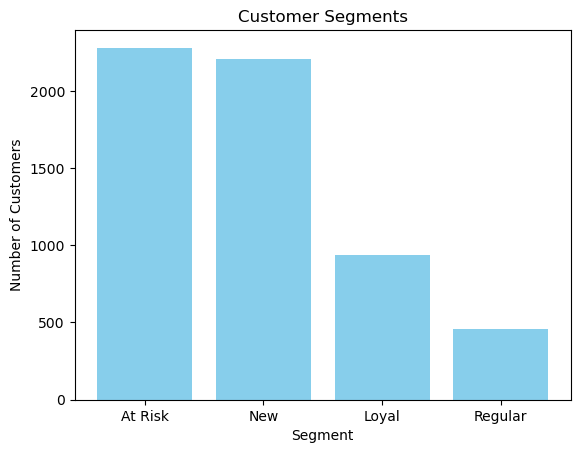

In [22]:
# Now visualizing the segments
# count of each segment
segment_counts = rfm['Segment'].value_counts()

plt.bar(segment_counts.index, segment_counts.values, color='skyblue')
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()

In [23]:
# Churn Analysis & Revenue Insights
# Let’s say customers who haven’t purchased in the last 180 days (6 months) are “churned”.
# create a churn flag based on Recency
rfm['Churned'] = np.where(rfm['Recency'] > 180, 'Yes', 'No')

# check how many churned
print(rfm['Churned'].value_counts())

Churned
No     3481
Yes    2400
Name: count, dtype: int64


In [24]:
# simple churn rate
total_customers = len(rfm)
churned_customers = len(rfm[rfm['Churned'] == 'Yes'])

churn_rate = (churned_customers / total_customers) * 100

print("Total Customers:", total_customers)
print("Churned Customers:", churned_customers)
print("Churn Rate: {:.2f}%".format(churn_rate))

Total Customers: 5881
Churned Customers: 2400
Churn Rate: 40.81%


In [25]:
# compare revenue between churned and active customers
revenue_by_churn = rfm.groupby('Churned')['Monetary'].sum().reset_index()

print(revenue_by_churn)

  Churned      Monetary
0      No  1.534999e+07
1     Yes  2.393443e+06


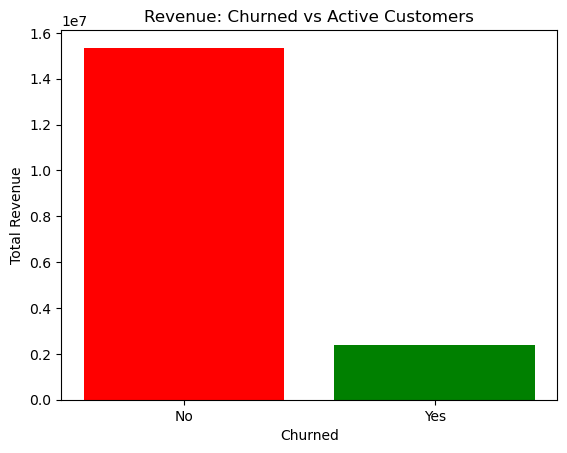

In [26]:
# simple bar chart
plt.bar(revenue_by_churn['Churned'], revenue_by_churn['Monetary'], color=['red', 'green'])
plt.title('Revenue: Churned vs Active Customers')
plt.xlabel('Churned')
plt.ylabel('Total Revenue')
plt.show()

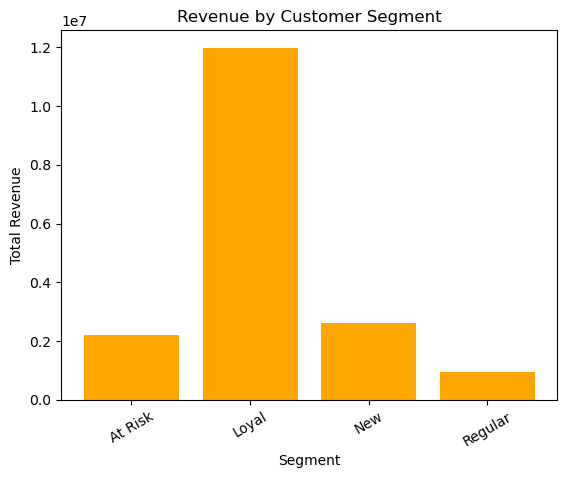

In [27]:
# total revenue per customer segment
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().reset_index()

plt.bar(segment_revenue['Segment'], segment_revenue['Monetary'], color='orange')
plt.title('Revenue by Customer Segment')
plt.xlabel('Segment')
plt.ylabel('Total Revenue')
plt.xticks(rotation=30)
plt.show()

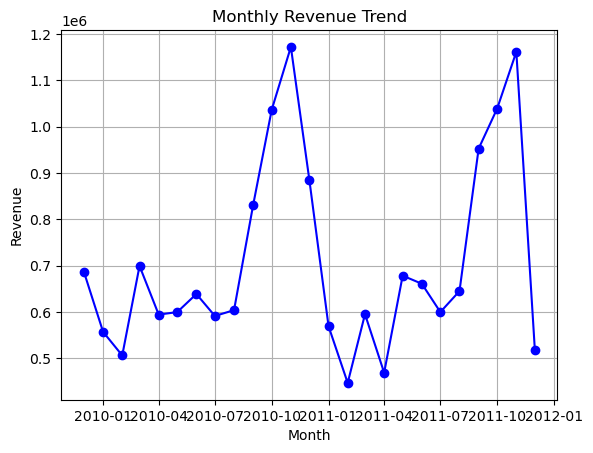

In [29]:
# Let’s see how the company’s revenue changes over time.
# make sure we have InvoiceMonth column
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp()

monthly_revenue = df.groupby('InvoiceMonth')['TotalAmount'].sum().reset_index()

plt.plot(monthly_revenue['InvoiceMonth'], monthly_revenue['TotalAmount'], marker='o', color='blue')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

In [33]:
# Exporting Data for Power BI Dashboard
# We’ll export RFM + churn + segment data into a clean CSV file.

export_data = rfm[['Customer_ID', 'Recency', 'Frequency', 'Monetary', 'Segment', 'Churned']]

# export to CSV
export_data.to_excel('Ecommerce_Customer_RFM.xlsx', index=False, sheet_name='RFM_Data')

print("File saved successfully: Ecommerce_Customer_RFM.xlsx")

File saved successfully: Ecommerce_Customer_RFM.xlsx
